In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from matplotlib import pyplot as plt
from sklearn import preprocessing
from scipy.stats import ttest_1samp
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

FileNotFoundError: [WinError 3] Le chemin d’accès spécifié est introuvable: '../input'

# What are we trying to do?
We are trying to figure out the best consulates to apply for to have the highest odds for receiving a uniform visa in general, or a multiple entry visa (MEV) in particular. Along the way, we would also carry out interesting analysis.

This kernel status is: Work In Progress

# Important Notice:
Although we would try to get a solid analytic study, there is no way we could know the actual quality of applications received by every consulate in different countries, having a higher rejection rate in a specific consulate could be the result of lower quality of application received in this consulate. But, given the sample size (applicants in consulate) and population size (applicants in all schengen consulates in country), we could carry out a hypothesis testing to figure out the possibility of such scenario to happen just to prove that it is highly unlikely that these numbers happened out of random chance.

# Data Cleaning:

In [2]:
# I will start from the raw xlsx source, luckily pandas has read_excel method which isn't very known
df = pd.read_excel('../input/2018-consulates-schengen-visa-stats.xlsx', sheet_name='Data for consulates')
df.head()

,Schengen State,Country where consulate is located,Consulate,Airport transit visas (ATVs) applied for,ATVs issued (including multiple),Multiple ATVs issued,ATVs not issued,Not issued rate for ATVs,Uniform visas applied for,Total uniform visas issued (including MEV),Multiple entry uniform visas (MEVs) issued,Share of MEVs on total number of uniform visas issued,Total LTVs issued,Uniform visas not issued,Not issued rate for uniform visas,Total ATVs and uniform visas applied for,"Total ATVs and uniform visas issued (including multiple ATVs, MEVs and LTVs)",Total ATVs and uniform visas not issued,Not issued rate for ATVs and uniform visas
0,Austria,ALBANIA,TIRANA,NaN,NaN,NaN,NaN,NaN,62.0,32.0,10.0,0.312500,21.0,9.0,0.145161,62.0,53.0,9.0,0.145161
1,Austria,ALGERIA,ALGIERS,NaN,NaN,NaN,NaN,NaN,2481.0,1658.0,1461.0,0.881182,1.0,822.0,0.331318,2481.0,1659.0,822.0,0.331318
2,Austria,ARGENTINA,BUENOS AIRES,NaN,NaN,NaN,NaN,NaN,16.0,16.0,16.0,1.000000,0.0,0.0,0.000000,16.0,16.0,NaN,NaN
3,Austria,AUSTRALIA,CANBERRA,NaN,NaN,NaN,NaN,NaN,2776.0,2653.0,989.0,0.372786,1.0,122.0,0.043948,2776.0,2654.0,122.0,0.043948
4,Austria,AZERBAIJAN,BAKU,1.0,1.0,1.0,0.0,0.0,1976.0,1895.0,1769.0,0.933509,2.0,79.0,0.039980,1977.0,1898.0,79.0,0.039960


Since we are not interested in ATVs (airport transit visas), I will just drop those columns. Column names contain /n and whitespaces which should to be removed first.

In [3]:
# Stripping column names
df.columns = [col.strip() for col in df.columns]
print(df.columns)

Index(['Schengen State', 'Country where consulate is located', 'Consulate',
       'Airport transit visas (ATVs) applied for',
       'ATVs issued (including multiple)', 'Multiple ATVs issued',
       'ATVs not issued', 'Not issued rate for ATVs',
       'Uniform visas applied for',
       'Total  uniform visas issued (including MEV)',
       'Multiple entry uniform visas (MEVs) issued',
       'Share of MEVs on total number of uniform visas issued',
       'Total LTVs issued', 'Uniform visas not issued',
       'Not issued rate for uniform visas',
       'Total ATVs and uniform visas applied for',
       'Total ATVs and uniform visas issued  (including multiple ATVs, MEVs and LTVs)',
       'Total ATVs and uniform visas not issued',
       'Not issued rate for ATVs and uniform visas'],
      dtype='object')


In [4]:
df.drop([
        'Airport transit visas (ATVs) applied for',
        'ATVs issued (including multiple)',
        'Multiple ATVs issued', 'ATVs not issued',
        'Not issued rate for ATVs',
        'Total ATVs and uniform visas applied for',
        'Total ATVs and uniform visas issued  (including multiple ATVs, MEVs and LTVs)',
        'Total ATVs and uniform visas not issued',
        'Not issued rate for ATVs and uniform visas'
        ], axis=1, inplace=True)

df.rename(columns={
                    'Schengen State': 'sch_state',
                    'Country where consulate is located': 'consulate_country',
                    'Consulate': 'consulate_city',
                    'Uniform visas applied for': 'applications',
                    'Total  uniform visas issued (including MEV)': 'uniform_visas_issued',
                    'Multiple entry uniform visas (MEVs) issued': 'mevs_issued',
                    'Share of MEVs on total number of uniform visas issued': 'mevs_share',
                    'Total LTVs issued': 'ltvs_issued',
                    'Uniform visas not issued': 'rejected',
                    'Not issued rate for uniform visas': 'rejection_rate'}, inplace=True)
df = df.dropna(how='all').reset_index(drop=True)
df.head()

,sch_state,consulate_country,consulate_city,applications,uniform_visas_issued,mevs_issued,mevs_share,ltvs_issued,rejected,rejection_rate
0,Austria,ALBANIA,TIRANA,62.0,32.0,10.0,0.312500,21.0,9.0,0.145161
1,Austria,ALGERIA,ALGIERS,2481.0,1658.0,1461.0,0.881182,1.0,822.0,0.331318
2,Austria,ARGENTINA,BUENOS AIRES,16.0,16.0,16.0,1.000000,0.0,0.0,0.000000
3,Austria,AUSTRALIA,CANBERRA,2776.0,2653.0,989.0,0.372786,1.0,122.0,0.043948
4,Austria,AZERBAIJAN,BAKU,1976.0,1895.0,1769.0,0.933509,2.0,79.0,0.039980


In [5]:
# Exploring nulls
df.isnull().sum()

sch_state                 3
consulate_country         3
consulate_city            0
applications              2
uniform_visas_issued     33
mevs_issued              82
mevs_share               47
ltvs_issued             477
rejected                180
rejection_rate            9
dtype: int64

In [6]:
# This is part is a summary in the sheet, we do not need it
df[df.sch_state.isnull()]

,sch_state,consulate_country,consulate_city,applications,uniform_visas_issued,mevs_issued,mevs_share,ltvs_issued,rejected,rejection_rate
1900,NaN,NaN,Selection Sub total in 2018,16016599.0,14265282.0,8325850.0,0.583644,113687.0,1539362.0,0.09611
1901,NaN,NaN,Total worldwide 2018,16016599.0,14265282.0,8325850.0,0.583644,113687.0,1539362.0,0.09611
1902,NaN,NaN,Share of subtotal on worldwide total,1.0,1.0,1.0,NaN,1.0,1.0,NaN


In [7]:
df = df.dropna(axis=0, subset=['sch_state']).reset_index(drop=True)
df.fillna(0, inplace=True) # Remaining nulls are zeros

Although the data should be pretty clean now, there are 2 things needed to be done:
1. Check for mis-calculated columns: \\(applications = uniform\_visas\_issued + ltvs\_issued + rejected\\) 

2. Drop the limited territory visas (LTVS) and remove their applications count as these visas are given under very specific circumstances that are not of the interest to most people or this analysis.



In [8]:
# finding any miscalculations 
df['decisions']  = df.uniform_visas_issued + df.ltvs_issued + df.rejected
print('More applications than descisions entries =', len(df[df.decisions < df.applications]))
print('More descisions than applications entries =', len(df[df.decisions > df.applications]))

More applications than descisions entries = 694
More descisions than applications entries = 55


We have a lot of unequal entries 
1. The first case (in my opinion) could be a result of applications currently under processing with no final descision taken yet. This could point out to a possible mistake in the raw data rejection_rate as it is just the division of \\(rejected/applicants\\) which is *obviously incorrect* and it should rather be \\(rejected/decisions\\).
2. The second case, more decisions than applications is rather weird but could possibly be late descision for case 1 (applications that happened in 2017 but descision taken in 2018), If it is the latter case, then it gets us to a another weird observation as case 1 is much bigger than case 2 (12.5x) while they should be pretty similar (applicants made in 2018 with descisions in 2019 should be somehow similar to descisions made in 2018 for applications in 2017) 

**In order to avoid confusion and get accurate results, I will use the descisions column instead of applications column after subtracting the LTVs, re-calculate the rejection_rate and proceed.**

In [9]:
df['decisions'] = df.decisions - df.ltvs_issued
df['applications'] = df.applications - df.ltvs_issued
df.drop('ltvs_issued', axis=1, inplace=True)
df['rejection_rate'] = df.rejected/df.decisions
df.head()

,sch_state,consulate_country,consulate_city,applications,uniform_visas_issued,mevs_issued,mevs_share,rejected,rejection_rate,decisions
0,Austria,ALBANIA,TIRANA,41.0,32.0,10.0,0.312500,9.0,0.219512,41.0
1,Austria,ALGERIA,ALGIERS,2480.0,1658.0,1461.0,0.881182,822.0,0.331452,2480.0
2,Austria,ARGENTINA,BUENOS AIRES,16.0,16.0,16.0,1.000000,0.0,0.000000,16.0
3,Austria,AUSTRALIA,CANBERRA,2775.0,2653.0,989.0,0.372786,122.0,0.043964,2775.0
4,Austria,AZERBAIJAN,BAKU,1974.0,1895.0,1769.0,0.933509,79.0,0.040020,1974.0


# Picking a country & starting the analysis:

In [10]:
# I am picking Egypt
country = 'EGYPT'
df_eg = df[df.consulate_country == country].reset_index(drop=True)
df_eg

,sch_state,consulate_country,consulate_city,applications,uniform_visas_issued,mevs_issued,mevs_share,rejected,rejection_rate,decisions
0,Austria,EGYPT,CAIRO,4954.0,4132.0,2872.0,0.695063,822.0,0.165927,4954.0
1,Belgium,EGYPT,CAIRO,3235.0,1946.0,464.0,0.238438,1111.0,0.363428,3057.0
2,Czech Republic,EGYPT,CAIRO,2710.0,2015.0,433.0,0.214888,693.0,0.255908,2708.0
3,Denmark,EGYPT,CAIRO,1789.0,1542.0,763.0,0.494812,238.0,0.133708,1780.0
4,Estonia,EGYPT,CAIRO,272.0,198.0,68.0,0.343434,74.0,0.272059,272.0
5,Finland,EGYPT,CAIRO,985.0,846.0,291.0,0.343972,131.0,0.134084,977.0
6,France,EGYPT,CAIRO,59824.0,45733.0,13514.0,0.295498,11941.0,0.207043,57674.0
7,Germany,EGYPT,CAIRO,38220.0,32848.0,26496.0,0.806624,5372.0,0.140555,38220.0
8,Greece,EGYPT,ALEXANDRIA,3210.0,2873.0,1633.0,0.568395,337.0,0.104984,3210.0
9,Greece,EGYPT,CAIRO,6500.0,5443.0,1502.0,0.275951,1057.0,0.162615,6500.0


**Which consulate receives the most applications?**

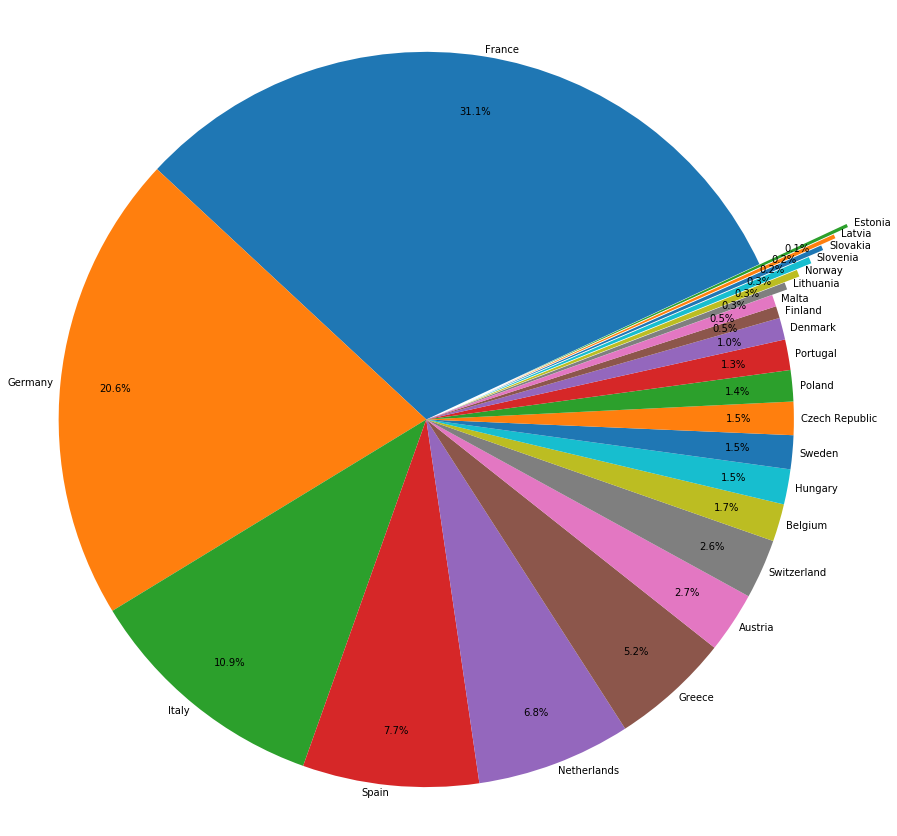

In [11]:
# pie chart
grouped_df = df_eg.groupby('sch_state').sum().decisions.nlargest(len(df_eg))
plt.figure(figsize=(15,15))
plt.subplot(111)
explode_thr = 16
plt.pie(grouped_df,
        labels=grouped_df.index,
        autopct='%.1f%%', shadow=False, pctdistance=0.85, labeldistance=1.02, startangle=25,
        explode = [0 if i < explode_thr else (i/len(grouped_df))-(explode_thr/len(grouped_df)) for i in range(len(grouped_df))])
plt.axis('equal')
plt.show()

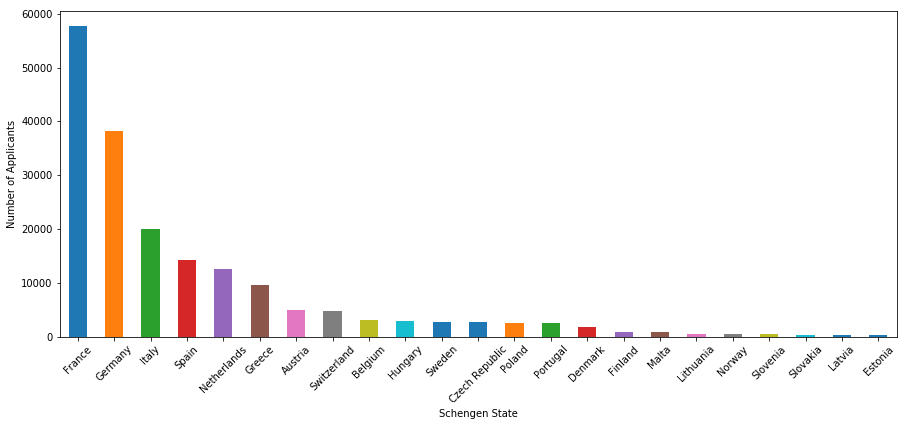

In [12]:
# bar chart
plt.figure(figsize=(15,6))
plt.subplot(111)

chart = grouped_df.plot('bar')
chart.set_xlabel('Schengen State')
chart.set_ylabel('Number of Applicants')
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
plt.show()

It is obvious that France receives the most applications in Egypt, followed by Germany, Italy and Spain.
But is France actually the best location to lodge the application regarding rejection rates and MEVs?

We will first consider the first parameter, rejection_rate, where we aim for the lowest one(if you have weak application).
Then, we will consider MEVs rate, where we aim for the highest one (if you have strong application).
Lastly, We will create an engineered feature using both parameter in case one is not sure about the strength of his application. (Highest MEV odds from rather low rejection consulates)

# Generous Consulates

In [13]:
# Consult this rating if your application is possibly weak yet seeking a visa (any)
# Least 15 rejection rates
df_eg[['sch_state', 'consulate_city', 'decisions', 'mevs_share', 'rejection_rate']]\
.sort_values(by=['rejection_rate'], ascending=True).iloc[:15]

,sch_state,consulate_city,decisions,mevs_share,rejection_rate
19,Slovakia,CAIRO,399.0,0.472973,0.072682
8,Greece,ALEXANDRIA,3210.0,0.568395,0.104984
18,Portugal,CAIRO,2486.0,0.251389,0.131134
16,Norway,CAIRO,561.0,0.303901,0.131907
3,Denmark,CAIRO,1780.0,0.494812,0.133708
5,Finland,CAIRO,977.0,0.343972,0.134084
7,Germany,CAIRO,38220.0,0.806624,0.140555
24,Switzerland,CAIRO,4858.0,0.559613,0.148827
9,Greece,CAIRO,6500.0,0.275951,0.162615
0,Austria,CAIRO,4954.0,0.695063,0.165927


In [14]:
# Consult this rating if your application is strong AND seeking MEV
df_eg[['sch_state', 'consulate_city', 'decisions', 'mevs_share', 'rejection_rate']]\
.sort_values(by=['mevs_share'], ascending=False).iloc[:15]

,sch_state,consulate_city,decisions,mevs_share,rejection_rate
20,Slovenia,CAIRO,537.0,1.000000,0.234637
15,Netherlands,CAIRO,12577.0,0.995572,0.317723
7,Germany,CAIRO,38220.0,0.806624,0.140555
11,Italy,CAIRO,20098.0,0.705579,0.246442
0,Austria,CAIRO,4954.0,0.695063,0.165927
8,Greece,ALEXANDRIA,3210.0,0.568395,0.104984
24,Switzerland,CAIRO,4858.0,0.559613,0.148827
3,Denmark,CAIRO,1780.0,0.494812,0.133708
19,Slovakia,CAIRO,399.0,0.472973,0.072682
12,Latvia,CAIRO,326.0,0.357143,0.226994


In [15]:
# Consult this rating if you are unsure about documents strength, yet, possibly seeking MEVs
# This rating is the sweet spot between acceptance rates and MEVs rates giving equal weights to both (normalized)
# Create a normalized engineered feature = (1-rejection_rate) * mevs_share
df_eg['score'] = (1 - df_eg['rejection_rate']) * df_eg.mevs_share
min_max_scaler = preprocessing.MinMaxScaler()
df_eg['score'] = min_max_scaler.fit_transform(df_eg[['score']].values)

df_eg[['sch_state', 'consulate_city', 'decisions', 'score']]\
.sort_values(by=['score'], ascending=False).iloc[:15]

,sch_state,consulate_city,decisions,score
20,Slovenia,CAIRO,537.0,1.000000
7,Germany,CAIRO,38220.0,0.902463
15,Netherlands,CAIRO,12577.0,0.883536
0,Austria,CAIRO,4954.0,0.748928
11,Italy,CAIRO,20098.0,0.683953
8,Greece,ALEXANDRIA,3210.0,0.652883
24,Switzerland,CAIRO,4858.0,0.609067
19,Slovakia,CAIRO,399.0,0.558034
3,Denmark,CAIRO,1780.0,0.544583
5,Finland,CAIRO,977.0,0.367669


# Stricter Consulates

In [16]:
#rejection_rates
df_eg[['sch_state', 'consulate_city', 'decisions', 'rejection_rate']]\
.sort_values(by=['rejection_rate'], ascending=False).iloc[:6]

,sch_state,consulate_city,decisions,rejection_rate
23,Sweden,CAIRO,2751.0,0.453653
1,Belgium,CAIRO,3057.0,0.363428
15,Netherlands,CAIRO,12577.0,0.317723
13,Lithuania,CAIRO,584.0,0.289384
4,Estonia,CAIRO,272.0,0.272059
2,Czech Republic,CAIRO,2708.0,0.255908


In [17]:
#mevs_rate
df_eg[['sch_state', 'consulate_city', 'decisions', 'mevs_share']]\
.sort_values(by=['mevs_share'], ascending=True).iloc[:6]

,sch_state,consulate_city,decisions,mevs_share
22,Spain,CAIRO,10609.0,0.031867
14,Malta,CAIRO,957.0,0.076633
21,Spain,ALEXANDRIA,3735.0,0.107638
17,Poland,CAIRO,2541.0,0.183448
2,Czech Republic,CAIRO,2708.0,0.214888
1,Belgium,CAIRO,3057.0,0.238438


In [18]:
# engineered score
df_eg[['sch_state', 'consulate_city', 'decisions', 'score']]\
.sort_values(by=['score'], ascending=True).iloc[:6]

,sch_state,consulate_city,decisions,score
22,Spain,CAIRO,10609.0,0.000000
14,Malta,CAIRO,957.0,0.051025
21,Spain,ALEXANDRIA,3735.0,0.074537
23,Sweden,CAIRO,2751.0,0.149183
17,Poland,CAIRO,2541.0,0.150049
1,Belgium,CAIRO,3057.0,0.170106


# Hypothesis Testing - Could this results be just a random chance?
In order to answer this question correctly, we need to define the population and the sample we will use:
1. Population: Total number of applicants/rejects in all the country.
2. Sample: Total number of applicants/rejects in all the targeted consulates.
The null hypothesis, which is a prediction that there is no significant difference between a specific consulate over all other consulates and that these numbers could have happened out naturally due to fluctations in application qualities received.
In order to proceed with this, we need to make a rather **BIG** assumption, that all applications to all consulates have the same *average* quality or that they came from the same pool/population.

Although this could not be known for sure, one can make an educated guess that it should rather be true, given that all applications came from Egypt (same country), targeted to Europe which has mostly a good living standard. There shouldn't be any reason to consider that Netherlands receives applications from a different population than Germany. or that Portugal receives higher quality applications than Spain.

We can conduct this using univariate T-test.

In [19]:
population_decisions = df_eg.decisions.sum()
population_rejects = df_eg.rejected.sum()
population_rejection_mean = population_rejects/population_decisions
print('Average rejection rate in Egypt for Schengen Visas in 2018: {:.2f}%'.format(population_rejection_mean*100))

Average rejection rate in Egypt for Schengen Visas in 2018: 20.46%


I will pick the consulates that have higher/lower rejection rates than average to see if there is a possibility given the sample sizes that all this happened out of pure chance.

In [20]:
# Consulates having better than average acceptance rates:
top_generous = df_eg[['sch_state', 'consulate_city', 'decisions', 'rejected', 'rejection_rate']]\
.sort_values(by=['rejection_rate'], ascending=True)
top_generous = top_generous[top_generous.rejection_rate < population_rejection_mean]

In [21]:
# To demonstrate how unlikely this could happen, I will use p = 0.001 as a threshold
def hypothesis_testing(df, state):
    null_hytothesis_accepted = []
    null_hytothesis_rejected = []
    for idx, consulate in df.iterrows():
        N = int(consulate.decisions)
        K = int(consulate.rejected) # K rejects, N-K accepts
        arr = np.array([1] * K + [0] * (N-K))
        np.random.shuffle(arr)
        tstat, pval = ttest_1samp(arr, population_rejection_mean)
        if pval < 0.001:
            null_hytothesis_rejected.append(str(consulate.sch_state) + ' in ' + str(consulate.consulate_city))
        else:
            null_hytothesis_accepted.append(str(consulate.sch_state) + ' in ' + str(consulate.consulate_city))
    print('Null Hypothesis REJECTED, {} acceptance rates than average that COULDN\'T happen by chance: \n{}'.format(state, '\n'.join(null_hytothesis_rejected)))
    print('--------------------------------------------------------------------------------------------\n')
    print('Null Hypothesis ACCEPTED, {} acceptance rates than average that COULD have happend by chance: \n{}'.format(state, '\n'.join(null_hytothesis_accepted)))
hypothesis_testing(top_generous, 'better')

Null Hypothesis REJECTED, better acceptance rates than average that COULDN'T happen by chance: 
Slovakia in CAIRO
Greece in ALEXANDRIA
Portugal in CAIRO
Norway in CAIRO
Denmark in CAIRO
Finland in CAIRO
Germany in CAIRO
Switzerland in CAIRO
Greece in CAIRO
Austria in CAIRO
Spain in CAIRO
--------------------------------------------------------------------------------------------

Null Hypothesis ACCEPTED, better acceptance rates than average that COULD have happend by chance: 
Malta in CAIRO


Only Malta, due to the low count of applications, we can not be very sure about it. (we can actually be sure too as p-value threshold of 0.001 is extremely low and have been used to show the difference.

In [22]:
most_strict = df_eg[['sch_state', 'consulate_city', 'decisions', 'rejected', 'rejection_rate']]\
.sort_values(by=['rejection_rate'], ascending=False)
most_strict = most_strict[most_strict.rejection_rate > population_rejection_mean]
hypothesis_testing(most_strict, 'lower')

Null Hypothesis REJECTED, lower acceptance rates than average that COULDN'T happen by chance: 
Sweden in CAIRO
Belgium in CAIRO
Netherlands in CAIRO
Lithuania in CAIRO
Czech Republic in CAIRO
Poland in CAIRO
Hungary in CAIRO
Italy in CAIRO
Spain in ALEXANDRIA
--------------------------------------------------------------------------------------------

Null Hypothesis ACCEPTED, lower acceptance rates than average that COULD have happend by chance: 
Estonia in CAIRO
Slovenia in CAIRO
Latvia in CAIRO
France in CAIRO


**It is clear that generally for the most 11 generous and most 9 strict, we can be confident that this didn't happen by random chance and there is probably different scoring criteria for applications in different consulates.**

# Countries Rating

In [23]:
# In order to get this correctly, we need to check for inappropriate data entries
df[df.mevs_issued > df.uniform_visas_issued]

,sch_state,consulate_country,consulate_city,applications,uniform_visas_issued,mevs_issued,mevs_share,rejected,rejection_rate,decisions
13,Austria,CROATIA,ZAGREB,238.0,224.0,235.0,1.049107,14.0,0.058824,238.0
20,Austria,INDIA,NEW DELHI,36794.0,34792.0,34812.0,1.000575,2002.0,0.054411,36794.0
35,Austria,NORTH MACEDONIA,SKOPJE,356.0,15.0,922.0,61.466667,341.0,0.957865,356.0
41,Austria,SAUDI ARABIA,RIYADH,9531.0,9179.0,12148.0,1.323456,352.0,0.036932,9531.0
46,Austria,SOUTH AFRICA,PRETORIA,5744.0,5615.0,6255.0,1.113980,129.0,0.022458,5744.0
710,Greece,ALBANIA,KORCE,9.0,8.0,15.0,1.875000,1.0,0.111111,9.0
735,Greece,CROATIA,ZAGREB,13.0,13.0,14.0,1.076923,0.0,0.000000,13.0
757,Greece,KOSOVO,PRISTINA,883.0,314.0,4649.0,14.805732,569.0,0.644394,883.0
778,Greece,SERBIA,BELGRADE,210.0,210.0,212.0,1.009524,0.0,0.000000,210.0
799,Greece,USA,"CHICAGO, IL",601.0,596.0,601.0,1.008389,5.0,0.008319,601.0


This entries are incorrect, there is no explanation for these entries that I can think of.

mevs_share should not under any circumstances exceed 1.0

For the first rating, using rejection_rate, we can ignore those mistakes but for ratings over mevs_share, I have no option other than dropping those rows.

**I am also dropping consulates inside the Schengen Zone as this situatioin does not reflect anything really (the applicants will mostly not be citizens of this countires but rather statless/illegal immigrants/etc). Also, I will drop countries with extremely low decisions < 100**

In [24]:
world_rejects = df[~df.consulate_country.isin([sch_state.upper() for sch_state in df.sch_state.values])]\
                .groupby('consulate_country').sum()\
                .groupby(level=0).filter(lambda x: x.decisions > 100)
world_rejects['rejection_rate'] = world_rejects.rejected/world_rejects.decisions
highest_rejections = world_rejects.sort_values(by=['rejection_rate'], ascending=False).drop(['mevs_issued', 'mevs_share'], axis=1)
print('{} is the {}th hardest country to get a schengen visa from {} total countries'.format(country, highest_rejections.index.get_loc(country), len(highest_rejections)))

world_mevs = df[(df.mevs_share <= 1) & (~df.consulate_country.isin([sch_state.upper() for sch_state in df.sch_state.values]))]\
                .groupby('consulate_country').sum()\
                .groupby(level=0).filter(lambda x: x.decisions > 100)
world_mevs['mevs_share'] = world_mevs.mevs_issued/world_mevs.uniform_visas_issued
lowest_mevs = world_mevs.sort_values(by=['mevs_share'], ascending=True)
print('{} is the {}th hardest country to get a MEV schengen visa from {} total countries'.format(country, lowest_mevs.index.get_loc(country), len(lowest_mevs)))

EGYPT is the 40th hardest country to get a schengen visa from 134 total countries
EGYPT is the 91th hardest country to get a MEV schengen visa from 134 total countries


# Hardest Countries

In [25]:
#highest_rejections.iloc[:highest_rejections.index.get_loc(country) + 1]

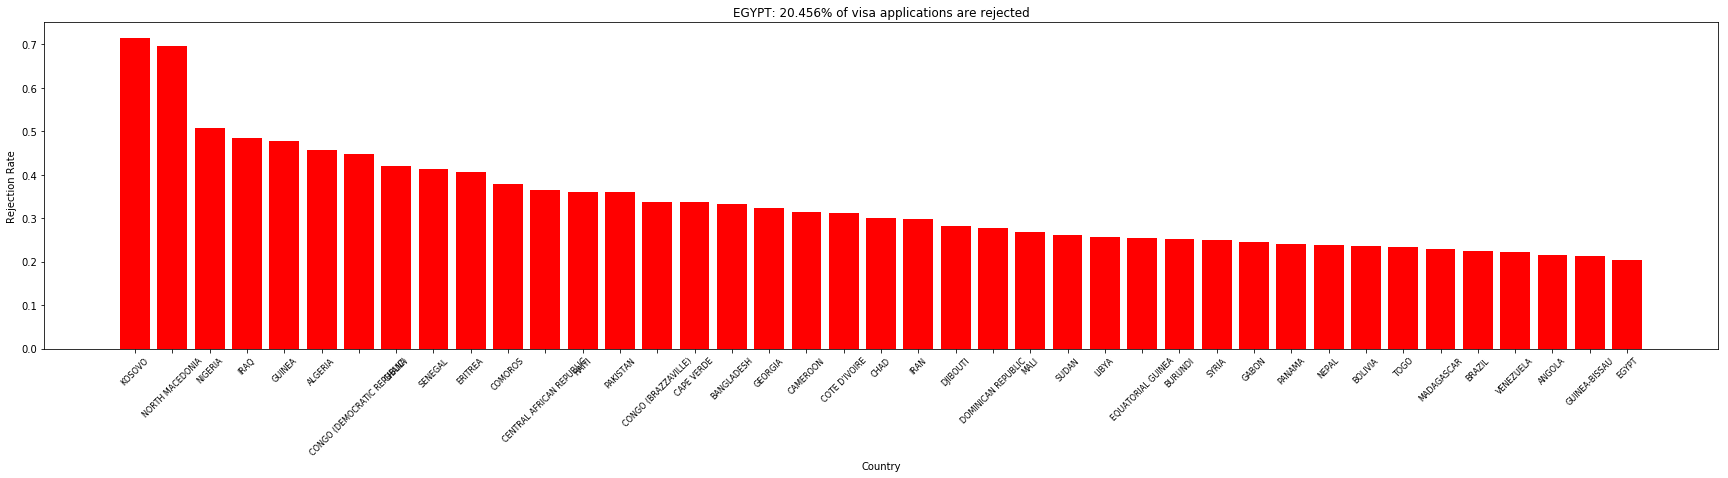

In [26]:
# Rejection Rates:
plt.figure(figsize=(30,6))
plt.title('{}: {:.3f}% of visa applications are rejected'.format(country, highest_rejections.loc[country].rejection_rate*100))
plt.bar(highest_rejections.iloc[:highest_rejections.index.get_loc(country) + 1].index, highest_rejections.iloc[:highest_rejections.index.get_loc(country) + 1].rejection_rate, color='r')
plt.xlabel('Country')
plt.ylabel('Rejection Rate')
plt.xticks(rotation=45, fontsize=8)
plt.show()

In [27]:
#lowest_mevs.iloc[:lowest_mevs.index.get_loc(country) + 1]

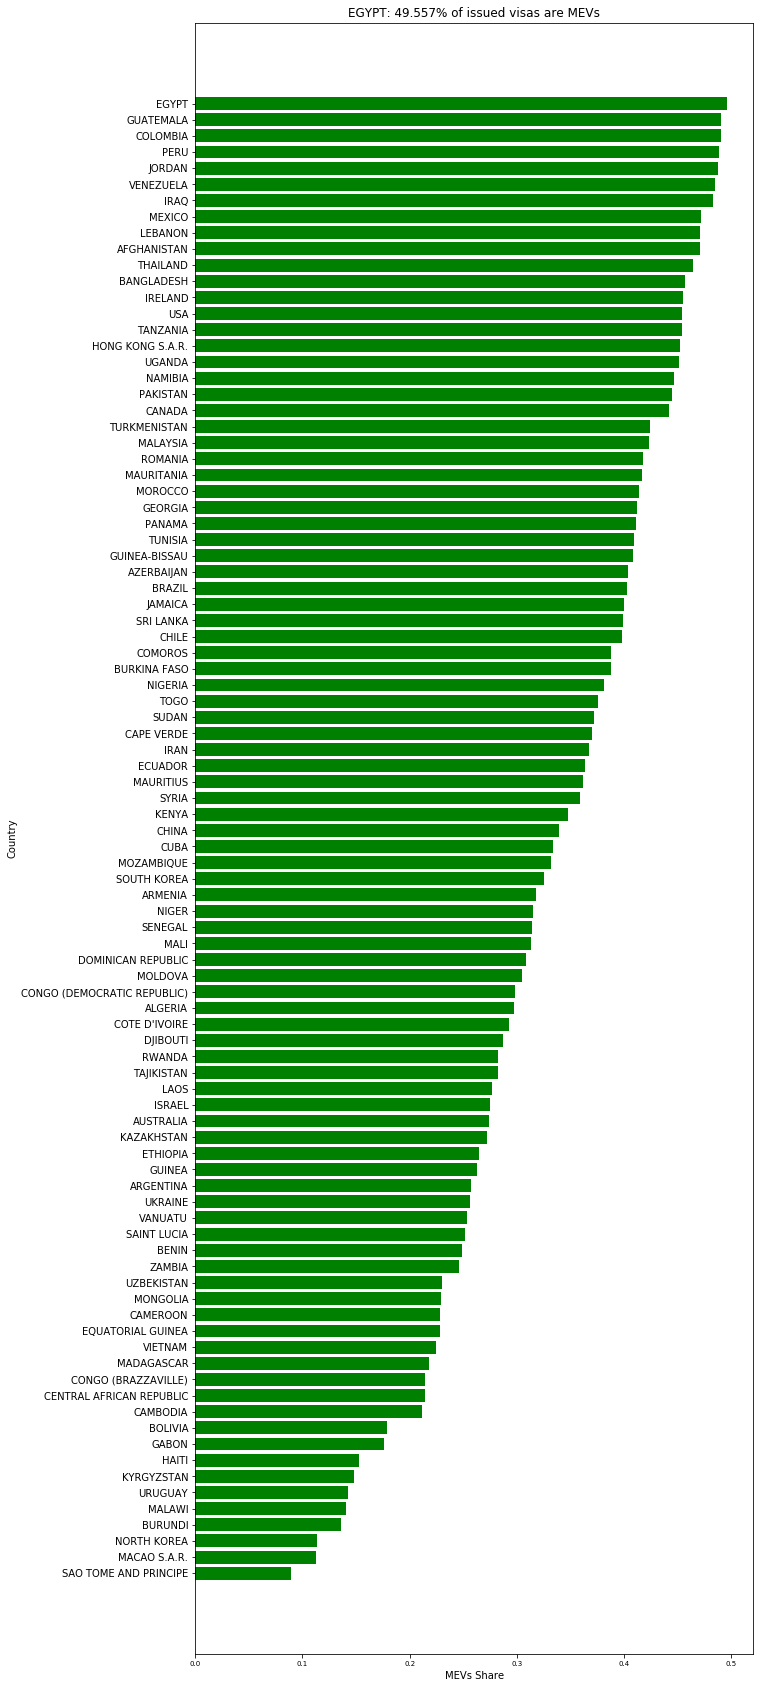

In [28]:
# MEVs Share:
plt.figure(figsize=(10,30))
#plt.subplot(111)
plt.barh(lowest_mevs.iloc[:lowest_mevs.index.get_loc(country) + 1].index, lowest_mevs.iloc[:lowest_mevs.index.get_loc(country) + 1].mevs_share, color='g')
plt.title('{}: {:.3f}% of issued visas are MEVs'.format(country, lowest_mevs.loc[country].mevs_share*100))
plt.xlabel('MEVs Share')
plt.ylabel('Country')
plt.axis('tight')
plt.xticks(rotation=0, fontsize=7)
plt.show()

Feel free to fork the kernel if you want to apply the same analysis on a different country!